In [48]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from pathlib import Path
import json
import os

sys.path.append(str(Path.cwd().parent))

from vae import generate, sample, dump
from src.load_model import load_model
import src.utils as utils

### Compare Models with diffrent latent dimensions

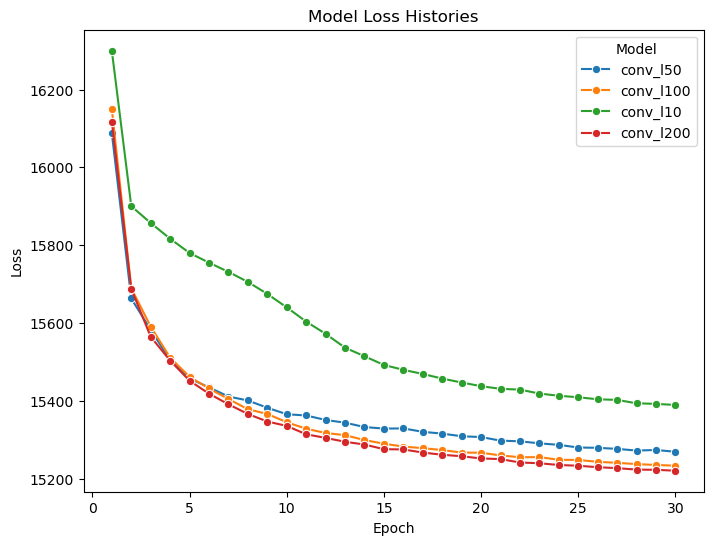

In [62]:
# Model comparison
models_path = "../models/shapes/"
loss_histories = []
# get dirs in models_path
models = os.listdir(models_path)

# Load loss histories from each model
for model in models:
    config = utils.load_model_config(os.path.join(models_path, model))
    loss_histories.append((model, config["loss_history"]))

# Prepare data for plotting
data = []
for model, history in loss_histories:
    for epoch, loss in enumerate(history):
        data.append({"Model": model, "Epoch": epoch + 1, "Loss": loss})

# Convert data to a DataFrame
df = pd.DataFrame(data)

# Plot using Seaborn
plt.figure(figsize=(8, 6))
sns.lineplot(data=df, x="Epoch", y="Loss", hue="Model", marker="o")
plt.title('Model Loss Histories')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(title='Model')
plt.show()

Define model and where to find the trained data

In [63]:
model_path = "../models/shapes/conv_l200"
dataset_path = "../data/shapes/"
model, device = load_model(model_path)
config = utils.load_model_config(model_path)

if config["grayscale"]:
    plt.rcParams['image.cmap'] = "gray"

## Sample

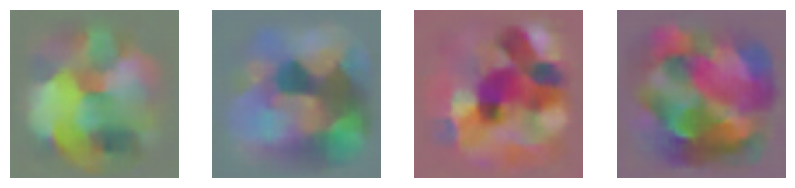

In [64]:
n = 4

plt.figure(figsize=(10, 5))

for i in range(n):
    output = model.sample(device)
    img = utils.convert_tensor_to_image(output)
    plt.subplot(1, n, i+1)
    plt.imshow(img)
    plt.axis("off")

plt.show()

## Create CSV Dump

Create dump of dataset to visualize latent space

In [65]:
# dump_path = "../dumps/shapes/conv_l200.csv"

# dump(model_path, input=dataset_path, save=dump_path)

Latent vectors saved to ../dumps/shapes/conv_l200.csv

In [66]:
# load dump
dump_path = "../dumps/shapes/conv_l200.csv"
df = pd.read_csv(dump_path)

# convert string to list
df['mean'] = df['mean'].apply(json.loads)
df['std'] = df['std'].apply(json.loads)

# if dump was created at other path, change the path in the dump
# df['path'] = df['path'].apply(lambda x: os.path.join("../", x))

df.head()

,image,label,mean,std
0,../data/shapes/Square/Square_39a673d2-2a91-11e...,Square,"[0.04593349248170853, 0.07123655080795288, 0.0...","[0.2330063134431839, 0.13303790986537933, 0.24..."
1,../data/shapes/Square/Square_83dead92-2a8d-11e...,Square,"[-0.46276113390922546, 1.4679073095321655, -1....","[0.28185907006263733, 0.16545842587947845, 0.3..."
2,../data/shapes/Square/Square_7569c2f2-2a87-11e...,Square,"[0.2661955654621124, -0.34401988983154297, -0....","[0.20407189428806305, 0.1846463978290558, 0.26..."
3,../data/shapes/Square/Square_f24ad714-2a8e-11e...,Square,"[0.3863808214664459, 0.9550507068634033, 0.451...","[0.1780148446559906, 0.14948971569538116, 0.20..."
4,../data/shapes/Square/Square_732fb29c-2a98-11e...,Square,"[0.20465710759162903, 2.5418992042541504, -0.1...","[0.06964055448770523, 0.0648910403251648, 0.08..."


## Visuzalize the Reconstructed Image

[ 4573  4802 28104 19372 17772]


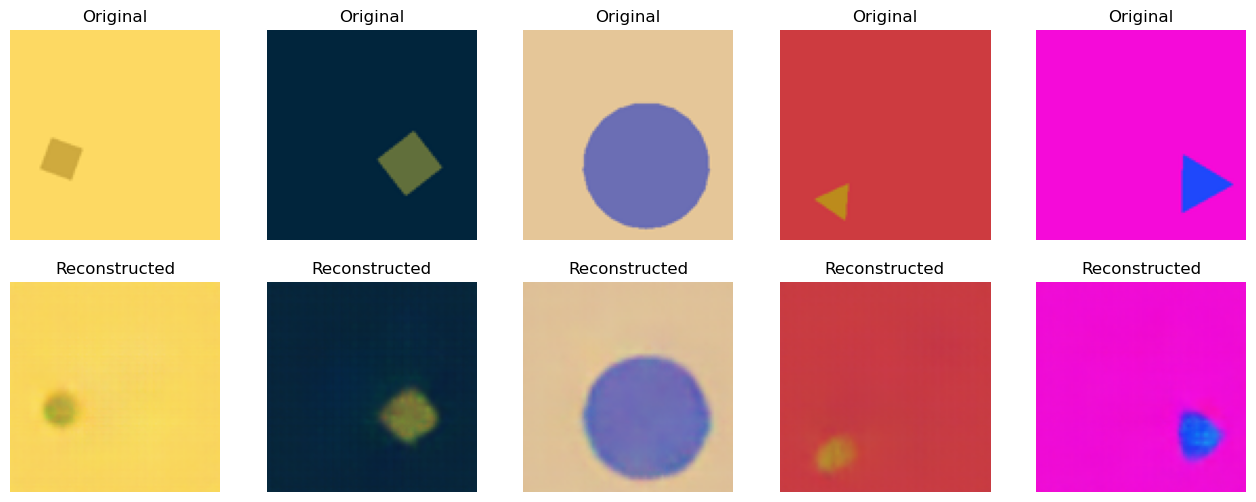

In [77]:
amount = 5
ids = np.random.choice(df.index, amount)
print(ids)

plt.figure(figsize=(16, 6))

for i, id in enumerate(ids):
    org_img_path = df.iloc[id].image
    mean, std = np.array(df.iloc[id]["mean"]), np.array(df.iloc[id]["std"])
    epsilon = np.random.normal(0, 1, mean.shape)
    latent_vector = mean + epsilon * std
    # change dtype to float32
    latent_vector = np.array(latent_vector, dtype=np.float32)

    output = model.generate(latent_vector, device)
    image = utils.convert_tensor_to_image(output)
    plt.subplot(2, amount, i+1)
    org_image = Image.open(org_img_path).resize(config["resize"])
    plt.imshow(org_image)
    plt.axis("off")
    plt.title("Original")
    plt.subplot(2, amount, i+1 + amount)
    plt.imshow(image)
    plt.axis("off")
    plt.title("Reconstructed")

## Add Noise to the latent vector

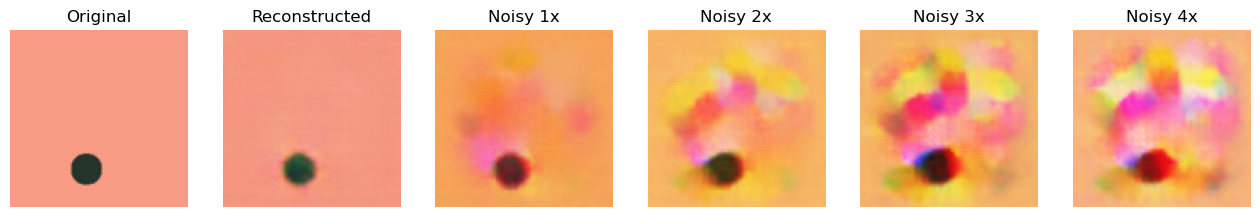

In [78]:
amount = 4
id = np.random.choice(df.index, 1)[0]

plt.figure(figsize=(16, 6))
org_img_path = df.iloc[id].image
mean, std = np.array(df.iloc[id]["mean"]), np.array(df.iloc[id]["std"])
epsilon = np.random.normal(0, 1, mean.shape)
latent_vector = mean + epsilon * std
# change dtype to float32
latent_vector = np.array(latent_vector, dtype=np.float32)

output = model.generate(latent_vector, device)
image = utils.convert_tensor_to_image(output)
plt.subplot(1, amount+2, 1)
org_image = Image.open(org_img_path).resize(config["resize"])
plt.imshow(org_image)
plt.axis("off")
plt.title("Original")
plt.subplot(1, amount+2, 2)
plt.imshow(image)
plt.axis("off")
plt.title("Reconstructed")

for i in range(amount):
    # add noise to the latent vector
    epsilon = np.random.normal(0, 1, latent_vector.shape)
    latent_vector += epsilon
    output = model.generate(latent_vector, device)
    image_noisy = utils.convert_tensor_to_image(output)
    plt.subplot(1, amount+2, i+3)
    plt.imshow(image_noisy)
    plt.axis("off")
    plt.title(f"Noisy {i+1}x")


## Interpolate

with gif

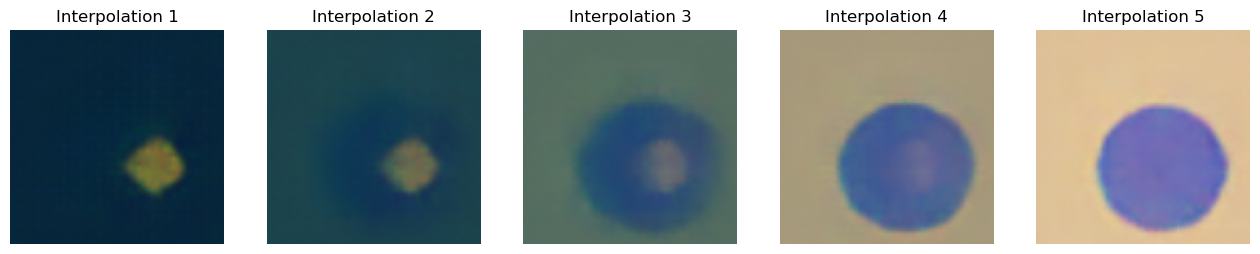

In [90]:
id_1, id_2 = 4802, 28104

def get_latent_vector(id, df):
    mean, std = np.array(df.iloc[id]["mean"]), np.array(df.iloc[id]["std"])
    epsilon = np.random.normal(0, 1, mean.shape)
    latent_vector = mean + epsilon * std
    latent_vector = np.array(latent_vector, dtype=np.float32)
    return latent_vector

latent_vector_1 = get_latent_vector(id_1, df)
latent_vector_2 = get_latent_vector(id_2, df)

# interpolate between two latent vectors
n = 5
latent_vectors = np.zeros((n, latent_vector_1.shape[0]), dtype=np.float32)
for i in range(n):
    # linear interpolation
    latent_vectors[i] = latent_vector_1 + (latent_vector_2 - latent_vector_1) * i / (n-1)
    
    
plt.figure(figsize=(16, 6))

for i, latent_vector in enumerate(latent_vectors):
    output = model.generate(latent_vector, device)
    image = utils.convert_tensor_to_image(output)
    plt.subplot(1, n, i+1)
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"Interpolation {i+1}")

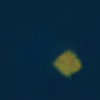

In [92]:
id_1, id_2 = 4802, 28104

latent_vector_1 = get_latent_vector(id_1, df)
latent_vector_2 = get_latent_vector(id_2, df)

# interpolate between two latent vectors
n = 50
latent_vectors = np.zeros((n, latent_vector_1.shape[0]), dtype=np.float32)
for i in range(n):
    # linear interpolation
    latent_vectors[i] = latent_vector_1 + (latent_vector_2 - latent_vector_1) * i / (n-1)

# create gif
images = []
for i, latent_vector in enumerate(latent_vectors):
    output = model.generate(latent_vector, device)
    image = utils.convert_tensor_to_image(output)
    images.append(image)
    
gif_path = "../images/interpolation.gif"
images[0].save(gif_path, save_all=True, append_images=images[1:], duration=100, loop=0)

# show gif
from IPython.display import Image
Image(filename=gif_path)

## Visualize 3D Lantent space with classes